In [1]:
import re
from itertools import combinations

import numpy as np
import pandas as pd
from textdistance import jaccard
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib import colors

In [2]:
domains = ['ribyhoroscop', 'devahoroscop', 'levhoroscop',
           'rakhoroscop', 'bliznetsihoroscop', 'ovenhoroscop',
           'telechoroscop', 'scorpionhoroscop', 'vodoleihoroscop',
           'kozeroghoroscop', 'vesyhoroscop', 'strelechoroscop']

In [3]:
posts_all = []
for domain in domains:
    posts = pd.read_csv('Data/with_duplicates_'+domain+'.csv', index_col=0)
    posts_all += [posts]

In [4]:
def split(x):
    res = re.split(re.compile(r'[,. !?;]+'), x.lower())
    while '' in res:
        res.remove('')
    return res

In [22]:
%%time
posts_splited_all = []
for posts in posts_all:
    posts_splited = pd.DataFrame(posts.text)
    posts_splited.text = posts_splited.text.map(split)
    posts_splited['is_unique'] = [False]*len(posts_splited)
    indexes = posts.text.drop_duplicates().index
    posts_splited.at[indexes, 'is_unique'] = [True] * len(indexes)
    posts_splited_all += [posts_splited]

Wall time: 2.79 s


In [50]:
%%time
distances_all = []
for posts_splited in posts_splited_all:
    texts = posts_splited[posts_splited.is_unique].text
    distances = []
    for i, j in combinations(texts.index, 2):
        dist = jaccard(texts[i], texts[j])
        distances.append((i, j, dist))
    distances_all += [distances]

Wall time: 3h 16min 16s


In [51]:
%%time
for distances in distances_all:
    distances = sorted(distances, key=lambda tup: tup[2], reverse=True)

Wall time: 1min 21s


In [52]:
%%time
for distances in distances_all:
    for tup in distances:
        if tup[2] < 0.59:
            break
        i = tup[0]
        j = tup[1]
        if posts_splited.is_unique[i] & posts_splited.is_unique[j]:
            if len(posts_splited.text[i]) > len(posts_splited.text[j]):
                posts_splited.is_unique.at[j] = False
            posts_splited.is_unique.at[i] = False

Wall time: 227 ms


In [86]:
all_texts = []
for text in posts_splited[posts_splited.is_unique].text:
    all_texts += text

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
 
# Create a list of word
text=' '.join(all_texts)
 
# Create the wordcloud object
wordcloud = WordCloud(width=1920, height=1080, margin=0, 
                      background_color='#F1F2F2', 
                      colormap=cm.twilight_shifted).generate(text)


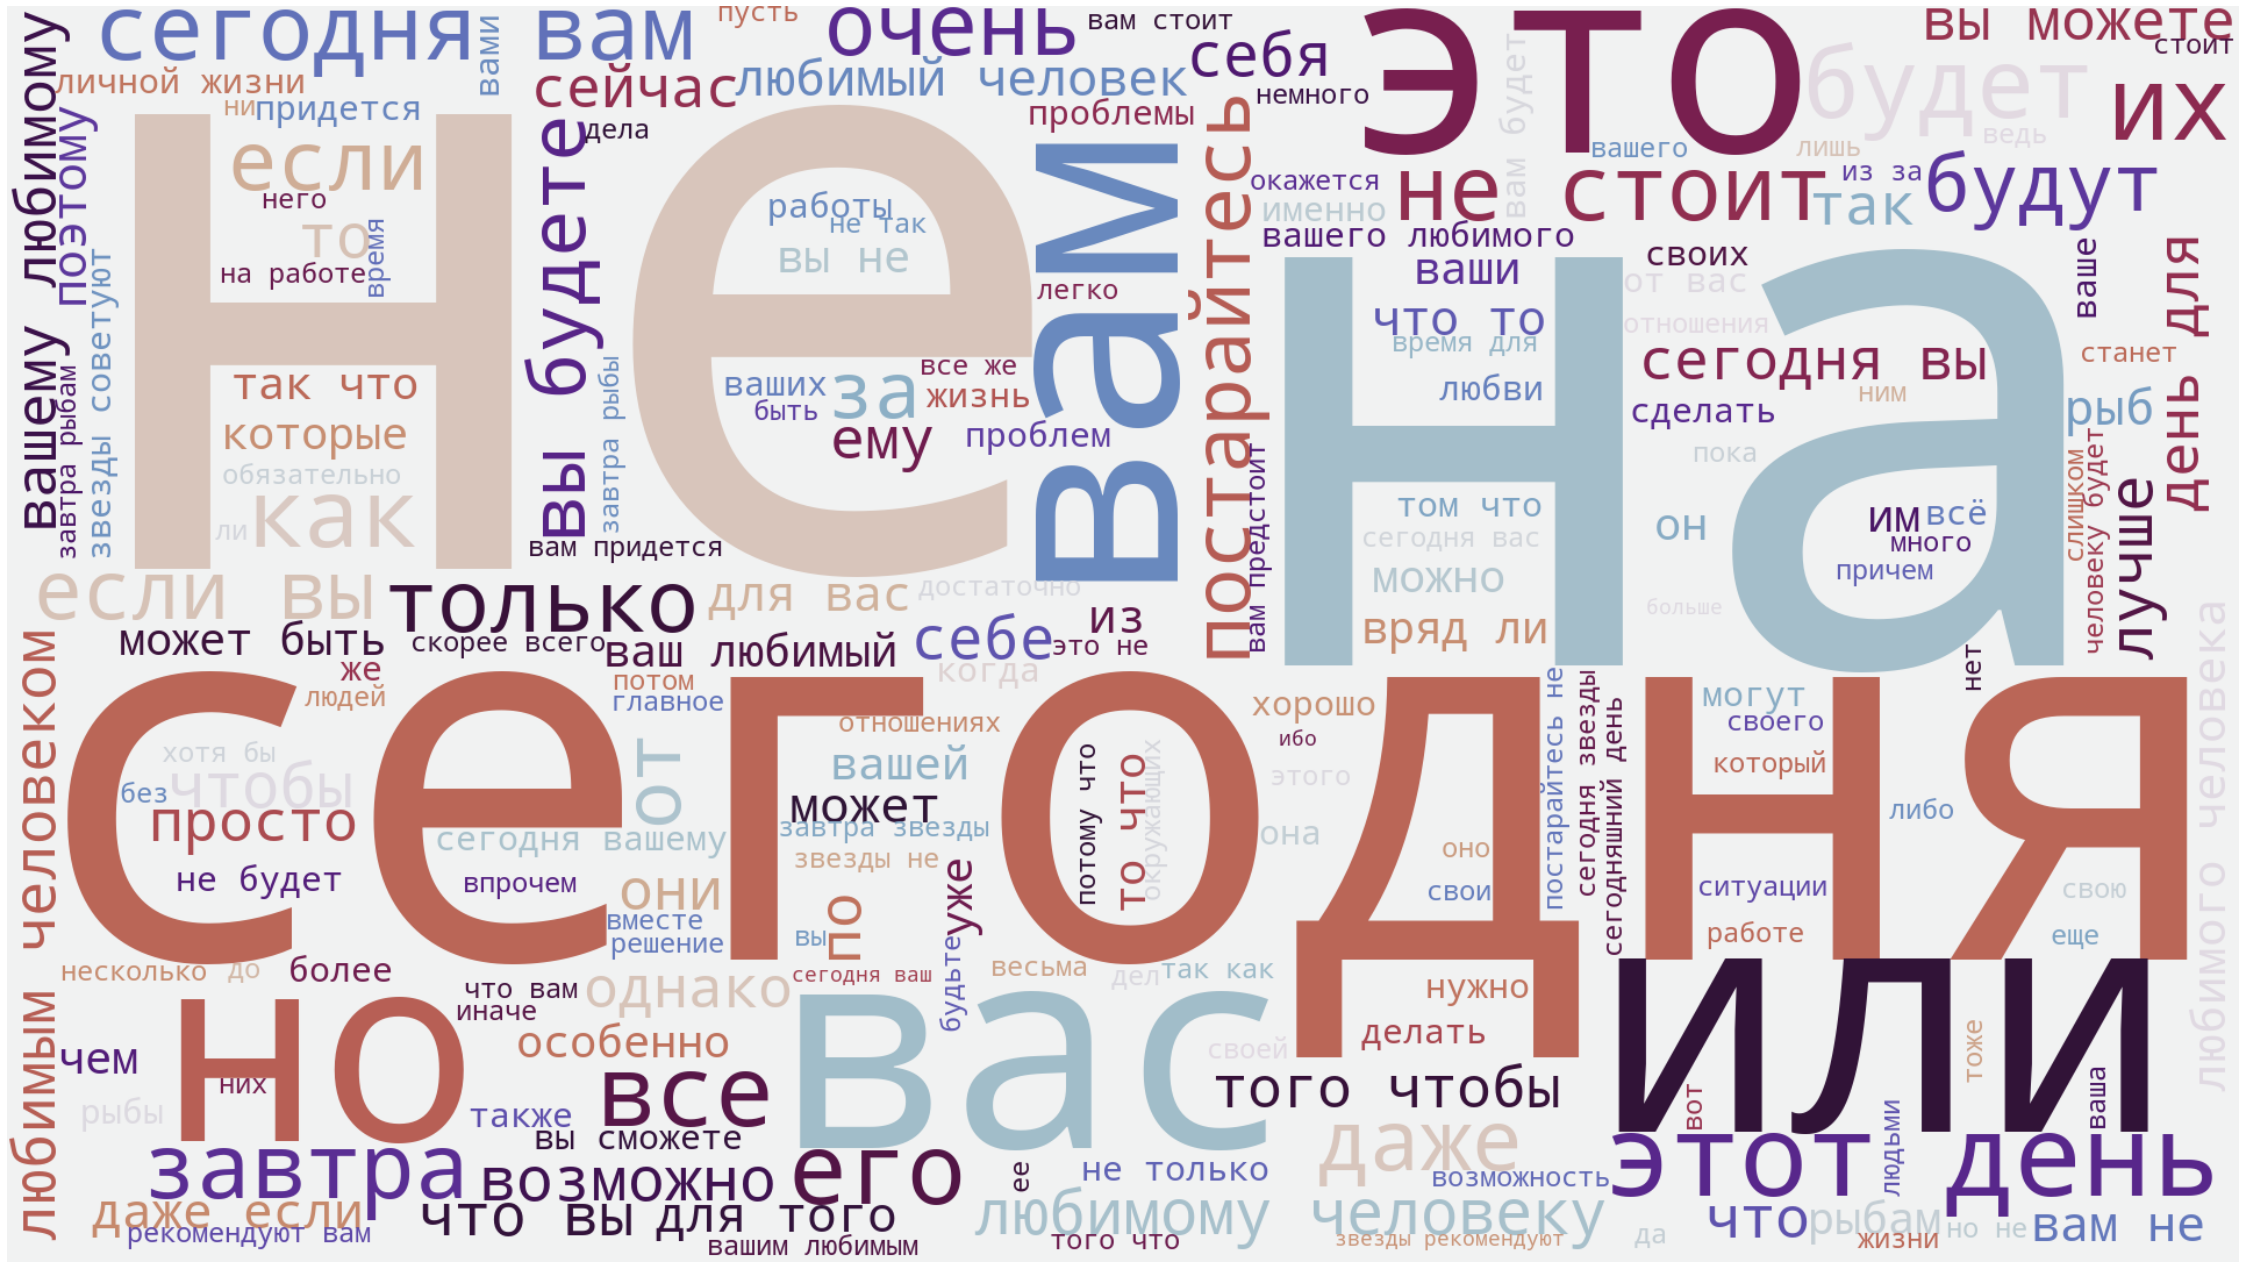

In [89]:
# Display the generated image:
plt.figure(figsize=(40, 40))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [57]:
for posts, posts_splited in zip(posts_all, posts_splited_all):
    posts['is_unique'] = posts_splited.is_unique

In [58]:
for posts, domain in zip(posts_all, domains):
    posts.to_csv('Data\\no_duplicates_' + domain + '.csv')

# Clear name of horoscope

In [59]:
stop_simple = ['Рыбы', 'Дева', 'Лев',
              'Рак', 'Близнецы', 'Овен',
              'Телец', 'Скорпион', 'Водолей',
              'Козерог', 'Весы', 'Стрелец']

In [60]:
change_hor = [{'рыбы': 'вы', 'рыбам': 'вам','рыб': 'вас'},
              {'дева': 'вы', 'девы': 'вы', 'девам': 'вам','дев': 'вас'},
              {'лев': 'вы', 'львы': 'вы', 'львам': 'вам','львов': 'вас'},
              {'рак': 'вы', 'раки': 'вы', 'ракам': 'вам','раков': 'вас'},
              {'близнецы': 'вы', 'близнецам': 'вам','близнецов': 'вас'},
              {'овен': 'вы', 'овны': 'вы', 'овнам': 'вам','овнов': 'вас'},
              {'телец': 'вы', 'тельцы': 'вы', 'тельцам': 'вам','тельцов': 'вас'},
              {'скорпион': 'вы', 'скорпионы': 'вы', 'скорпионам': 'вам','скорпионов': 'вас'},
              {'водолей': 'вы', 'водолеи': 'вы', 'водолеям': 'вам','водолеев': 'вас'},
              {'козерог': 'вы', 'козероги': 'вы', 'козерогам': 'вам','козерогов': 'вас'},
              {'весы': 'вы', 'весам': 'вам'},
              {'стрелец': 'вы', 'стрельцы': 'вы', 'стрельцам': 'вам','стрельцов': 'вас'}]

In [61]:
def replace(tup):
    res = tup[0].lower()
    dct = tup[1]
    for key in dct.keys():
        if key in res:
            res = res.replace(key, dct[key])
    return res

In [62]:
len(change_hor)

12

In [63]:
%%time
for posts, dct in zip(posts_all, change_hor):
    posts.text = list(map(replace, zip(posts.text, [dct]*len(posts.text))))

Wall time: 829 ms


In [64]:
months = ['января', 'февраля', 'марта',
          'апреля', 'мая', 'июня',
          'июля', 'августа', 'сентября',
          'октября', 'ноября', 'декабря']

months_2 = ['январб', 'феврал', 'март',
          'апрель', 'май', 'июнь',
          'июль', 'август', 'сентябрь',
          'октябрь', 'ноябрь', 'декабрь']

def sub(phrase):
        for month, month_2 in zip(months, months_2):
            if month in phrase:
                regexp_date = r'[1-9]?[0-9][ \t]+' + month
                pattern = re.compile(regexp_date, flags=re.I)
                if re.search(pattern, phrase):
                    phrase = re.sub(pattern, 'завтра', phrase)
                else:
                    phrase = phrase.replace(month, 'этого месяца')
            if month_2 in phrase:
                phrase = phrase.replace(month_2, 'этот месяц')
        return phrase

In [65]:
for posts in posts_all:
    posts.text = posts.text.map(sub)

In [67]:
for posts, domain in zip(posts_all, domains):
    posts.to_csv('Data\\no_duplicates_' + domain + '.csv')

# Concat all signs with no duplicates

In [68]:
posts_all = []
for domain in domains:
    posts = pd.read_csv('Data/no_duplicates_'+domain+'.csv', index_col=0)
    posts_all += [posts]

In [69]:
for posts, domain in zip(posts_all, domains):
    posts['domain'] = posts.index.map(lambda x: domain)
    posts['index_before_concat'] = posts.index

In [70]:
posts = pd.concat(posts_all, ignore_index=True)
posts = posts[posts.is_unique]

In [71]:
len(posts)

48276

In [72]:
posts.text.nunique()

27097

In [73]:
posts = posts.loc[posts.text.drop_duplicates().index]

In [75]:
posts.reset_index(drop=True, inplace=True)

In [82]:
%%time
posts_splited = posts.text.map(split)
posts_splited = posts_splited.map(lambda x: tuple(x))

Wall time: 659 ms


In [91]:
posts = posts.loc[posts_splited.drop_duplicates().index]
posts.reset_index(drop=True, inplace=True)

In [94]:
posts.drop(['is_unique'], axis=1, inplace=True)

In [130]:
len(posts)

26962

In [135]:
posts.to_csv('Data\\final_posts.csv')

In [138]:
posts = pd.read_csv('Data\\final_posts.csv', index_col=0)

In [139]:
posts

,text,length,date,type,index in posts,domain,index_before_concat
0,сегодня вы можете почувствовать незащищенность...,339,11 декабря,business,0,ribyhoroscop,0
1,вам звёзды рекомендуют сегодня больше работать...,303,11 декабря,love,0,ribyhoroscop,1
2,"если сегодня вы почувствуете робость, или, тог...",215,11 декабря,simple,0,ribyhoroscop,2
3,сегодня звезды рекомендуют вам заняться коррек...,278,10 декабря,business,1,ribyhoroscop,3
4,"сегодня ваш любимый человек признается в том, ...",273,10 декабря,love,1,ribyhoroscop,4
...,...,...,...,...,...,...,...
26957,"день преобразования космических энергий, получ...",544,2 марта,simple,2648,strelechoroscop,4575
26958,завтра - полон перемен для вас. поэтому строит...,256,1 марта,simple,2649,strelechoroscop,4576
26959,утром не мешкая приступайте к работе или завяз...,441,28 февраля,simple,2650,strelechoroscop,4577
26960,общительность и дружелюбие вас сегодня могут н...,453,27 февраля,simple,2651,strelechoroscop,4578


In [143]:
for i in posts.index:
    if '\ufeff' in posts.text[i]:
        posts.at[i, 'text'] = posts.text[i].replace('\ufeff', '')

In [145]:
pattern_year = re.compile(r'201[1-9] года?')
posts.text = posts.text.map(lambda x: re.sub(pattern_year, '', x))

In [146]:
posts.to_csv('Data\\final_posts.csv')